In [1]:
# Libraries for data loading, data manipulation and data visulisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from seaborn import pairplot
import plotly.express as px
from statsmodels.graphics.correlation import plot_corr

# Libraries for data preparation and model building
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import math
from statsmodels.graphics.correlation import plot_corr


import warnings
warnings.filterwarnings('ignore') # just to turn off or ignore minor warnings that may pop-up while executing codes.

# Setting global constants to ensure notebook results are reproducible
#PARAMETER_CONSTANT = ###

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

In [293]:
#Separate dates for future plotting

test_df = pd.read_csv("df_test.csv")
time = pd.to_datetime(test_df['time']) #pd.to_datetime(df['Date'])

In [ ]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

In [285]:
#Variables for training

df_train = pd.read_csv('df_train.csv', index_col='Unnamed: 0')
df_test = pd.read_csv('df_test.csv', index_col='Unnamed: 0')

In [286]:
concated_df = pd.concat([df_train, df_test], axis = 0)

In [287]:
concated_df['Time'] = pd.to_datetime(concated_df['time'], infer_datetime_format=True)

In [288]:
time = concated_df['Time']

In [289]:
dataset = concated_df[['Time', 'load_shortfall_3h']]

In [290]:
indexeddataset = dataset.set_index(['Time'])

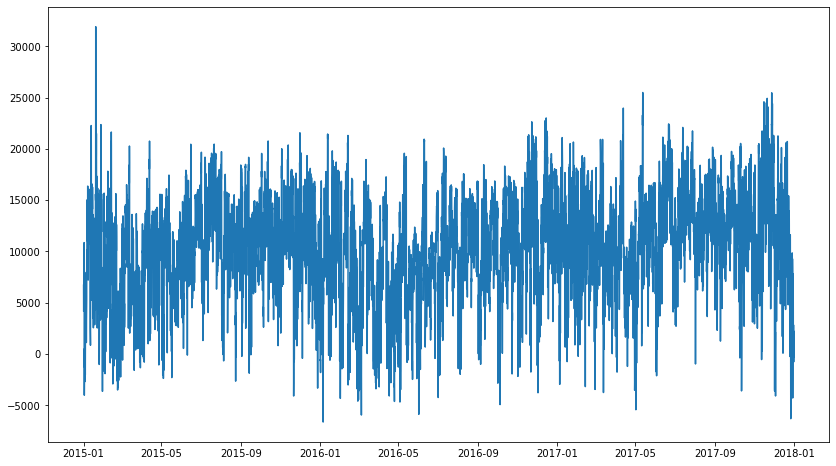

In [291]:
plt.figure(figsize=(14,8))
plt.plot(indexeddataset)

In [189]:
concated_df.columns

Index(['time', 'Madrid_wind_speed', 'Valencia_wind_deg', 'Bilbao_rain_1h',
       'Valencia_wind_speed', 'Seville_humidity', 'Madrid_humidity',
       'Bilbao_clouds_all', 'Bilbao_wind_speed', 'Seville_clouds_all',
       'Bilbao_wind_deg', 'Barcelona_wind_speed', 'Barcelona_wind_deg',
       'Madrid_clouds_all', 'Seville_wind_speed', 'Barcelona_rain_1h',
       'Seville_pressure', 'Seville_rain_1h', 'Bilbao_snow_3h',
       'Barcelona_pressure', 'Seville_rain_3h', 'Madrid_rain_1h',
       'Barcelona_rain_3h', 'Valencia_snow_3h', 'Madrid_weather_id',
       'Barcelona_weather_id', 'Bilbao_pressure', 'Seville_weather_id',
       'Valencia_pressure', 'Seville_temp_max', 'Madrid_pressure',
       'Valencia_temp_max', 'Valencia_temp', 'Bilbao_weather_id',
       'Seville_temp', 'Valencia_humidity', 'Valencia_temp_min',
       'Barcelona_temp_max', 'Madrid_temp_max', 'Barcelona_temp',
       'Bilbao_temp_min', 'Bilbao_temp', 'Barcelona_temp_min',
       'Bilbao_temp_max', 'Seville_temp_min'

In [294]:
# create a function to use in cleaning the test data

def engineer_data(df):
    # Read csv file into dataframe 
    #df = pd.read_csv(filepath)
    
    #Filling missing values
    df['Valencia_pressure'].fillna(df['Valencia_pressure'].mean(), inplace = True)
    
    # create new features
    df['Year']  = df['Time'].dt.year
    df['Month_of_year']  = df['Time'].dt.month
    df['Week_of_year'] = df['Time'].dt.weekofyear
    df['Day_of_year']  = df['Time'].dt.dayofyear
    df['Day_of_month']  = df['Time'].dt.day
    df['Day_of_week'] = df['Time'].dt.dayofweek
    #df['Hour_of_week'] = ((df['time'].dt.dayofweek) * 24 + 24) - (24 - df['time'].dt.hour)
    df['Hour_of_day']  = df['Time'].dt.hour

    # let us check our new features in the dataset with .info()
    #df.info()
    
    correlation_matrix = df.corr()
    correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    
    columns = list(correlated_features)
    
#     df.drop(columns, axis = 1, inplace = True)
#     df.drop('time', axis = 1, inplace = True)
    
    # Remove unwanted columns
#     df.drop(columns=['Unnamed: 0', 'time', 'Madrid_pressure', 'Valencia_temp_max', 'Valencia_temp', 'Seville_temp', 
#                  'Valencia_temp_min', 'Barcelona_temp_max', 'Madrid_temp_max', 'Barcelona_temp', 'Bilbao_temp_min', 
#                  'Bilbao_temp', 'Barcelona_temp_min', 'Bilbao_temp_max', 'Seville_temp_min', 'Seville_humidity', 'Madrid_temp', 
#                  'Madrid_temp_min', 'Week_of_year', 'Day_of_year', 'Hour_of_week'], inplace=True)


     #converting Valencia_wind_deg and Seville_pressure from object to numeric
    df['Valencia_wind_deg'] = df['Valencia_wind_deg'].str.extract('(\d+)').astype('float')
    df['Seville_pressure'] = df['Seville_pressure'].str.extract('(\d+)').astype('float')
    
    return df

In [296]:
cleaned_data = engineer_data(concated_df)

In [219]:
cleaned_time = cleaned_data['Time']
cleaned_time

0       2015-01-01 03:00:00
1       2015-01-01 06:00:00
2       2015-01-01 09:00:00
3       2015-01-01 12:00:00
4       2015-01-01 15:00:00
                ...        
11678   2018-12-31 09:00:00
11679   2018-12-31 12:00:00
11680   2018-12-31 15:00:00
11681   2018-12-31 18:00:00
11682   2018-12-31 21:00:00
Name: Time, Length: 11683, dtype: datetime64[ns]

In [41]:
time_column = ['Time', 'Year', 'Month_of_year', 'Day_of_month', 'Day_of_week', 'Hour_of_day']

In [220]:
cleaned_data.drop(['Time', 'time'], axis = 1, inplace = True)

In [221]:
cleaned_data

,Madrid_wind_speed,Valencia_wind_deg,Bilbao_rain_1h,Valencia_wind_speed,Seville_humidity,Madrid_humidity,Bilbao_clouds_all,Bilbao_wind_speed,Seville_clouds_all,Bilbao_wind_deg,...,Madrid_temp,Madrid_temp_min,load_shortfall_3h,Year,Month_of_year,Week_of_year,Day_of_year,Day_of_month,Day_of_week,Hour_of_day
0,0.666667,5.0,0.0,0.666667,74.333333,64.000000,0.000000,1.000000,0.0,223.333333,...,265.938000,265.938000,6715.666667,2015,1,1,1,1,3,3
1,0.333333,10.0,0.0,1.666667,78.333333,64.666667,0.000000,1.000000,0.0,221.000000,...,266.386667,266.386667,4171.666667,2015,1,1,1,1,3,6
2,1.000000,9.0,0.0,1.000000,71.333333,64.333333,0.000000,1.000000,0.0,214.333333,...,272.708667,272.708667,4274.666667,2015,1,1,1,1,3,9
3,1.000000,8.0,0.0,1.000000,65.333333,56.333333,0.000000,1.000000,0.0,199.666667,...,281.895219,281.895219,5075.666667,2015,1,1,1,1,3,12
4,1.000000,7.0,0.0,1.000000,59.000000,57.000000,2.000000,0.333333,0.0,185.000000,...,280.678437,280.678437,6620.666667,2015,1,1,1,1,3,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11678,0.333333,9.0,0.0,2.000000,81.666667,49.666667,80.000000,1.333333,0.0,70.000000,...,274.910000,271.150000,NaN,2018,12,1,365,31,0,9
11679,0.333333,8.0,0.0,1.333333,61.000000,28.333333,56.666667,1.000000,0.0,36.666667,...,283.156667,280.483333,NaN,2018,12,1,365,31,0,12
11680,1.000000,6.0,0.0,3.000000,47.000000,26.333333,0.000000,0.666667,0.0,14.666667,...,287.733333,286.483333,NaN,2018,12,1,365,31,0,15
11681,1.000000,6.0,0.0,2.000000,52.666667,56.666667,0.000000,0.666667,0.0,19.000000,...,283.813333,282.150000,NaN,2018,12,1,365,31,0,18


In [311]:
df_train_new = cleaned_data.iloc[:8763]
df_train_new.drop(['Time', 'time'], axis=1, inplace=True)

scaler = StandardScaler()
X_train_new_scaled = scaler.fit_transform(df_train_new)
df_X_train_new_scaled = pd.DataFrame(X_train_new_scaled, columns=df_train_new.columns)

y_train_new = df_X_train_new_scaled['load_shortfall_3h']

df_X_train_new_scaled.drop(['load_shortfall_3h'], axis=1, inplace=True)

In [320]:
df_test_new.shape

(2920, 54)

In [316]:
df_train_new.shape

(8763, 54)

In [318]:
df_test_new = cleaned_data.iloc[8763:]
time = df_test['Time']

df_test_new.drop(['Time', 'time'], axis=1, inplace=True)

X_test_new_scaled = scaler.transform(df_test_new)

df_X_test_new_scaled = pd.DataFrame(X_test_new_scaled, df_test_new.columns)
df_X_test_new_scaled.drop(['load_shortfall_3h'], axis=1, inplace=True)

ValueError: Shape of passed values is (2920, 54), indices imply (54, 54)

In [315]:
df_test_new.shape

(2920, 53)

In [303]:
df_train_new.shape

(8763, 53)

In [305]:
df_test_new.shape

(2920, 53)

In [307]:
y_train_new.shape

(8763,)

In [ ]:
model3 = LinearRegression()

model3.fit()

In [299]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(df_train)
# X_test_scaled = scaler.transform(df_test)

In [238]:
df_scaled_clean = pd.DataFrame(scaled_clean, columns=cleaned_data.columns)
X_train2 = df_scaled_clean.iloc[:8763]
X_test2 = df_scaled_clean.iloc[8763:]
y = df_scaled_clean['load_shortfall_3h']
y_train2 = y[:8763]

In [244]:
X_train2.drop('load_shortfall_3h', axis = 1, inplace=True)
X_test2.drop('load_shortfall_3h', axis = 1, inplace=True)

In [245]:
X_train2.shape

(8763, 53)

In [247]:
X_test2.shape

(2920, 53)

In [248]:
y_train2.shape

(8763,)

In [200]:
df_test.drop(['load_shortfall_3h', 'Time', 'time'], axis = 1, inplace = True)

In [202]:
df_test.shape

(2920, 53)

In [90]:
# cols = df_train.columns.tolist()

In [91]:
# cols = cols[-1:] + cols[:-1]

In [92]:
# df_train = df_train[cols]

In [166]:
# df_train.shape

(8763, 53)

In [210]:
scaler = StandardScaler()
scaler = scaler.fit(df_train)
df_for_training_scaled = scaler.transform(df_train)

In [214]:
#df_for_training_scaled
df_for_training_scaled = pd.DataFrame(df_for_training_scaled, columns=df_train.columns)
df_for_training_scaled.shape

(8763, 53)

In [203]:
y_train = df_train['load_shortfall_3h']
df_train.drop(['load_shortfall_3h', 'Time', 'time'], axis=1, inplace=True)

In [171]:
X_train = df_train

In [204]:
print(y_train.shape, X_train.shape, df_test.shape)

(8763,) (8763, 53) (2920, 53)


In [231]:
model = LinearRegression()

In [249]:
model2 = LinearRegression()

In [250]:
model2.fit(X_train2, y_train2)

LinearRegression()

In [319]:
X_test2 = scaler.transform(X_test2)

ValueError: X has 53 features, but StandardScaler is expecting 54 features as input.

In [276]:
prediction2 = model2.predict(X_test2)

prediction_new = np.reshape(prediction2, (-1, 2))
prediction_new

array([[-0.39378452, -0.46862245],
       [-0.22962346, -0.25315766],
       [-0.27685713, -0.1703132 ],
       ...,
       [-0.19629212, -0.08328043],
       [ 0.38559615,  0.74131148],
       [ 0.64897722,  0.40685267]])

In [279]:
trainPredict_dataset_like = np.zeros(shape=(len(prediction_new), 53))

In [280]:
trainPredict_dataset_like[:,0] = prediction_new[:,0]

In [282]:
# create empty table with 12 fields
trainPredict_dataset_like = np.zeros(shape=(len(prediction_new), 53))

# put the predicted values in the right field
trainPredict_dataset_like[:,0] = prediction_new[:,0]

# inverse transform and then select the right field
y_pred = scaler.inverse_transform(trainPredict_dataset_like)[:,0]

ValueError: operands could not be broadcast together with shapes (1460,53) (54,) (1460,53) 

In [254]:
y_pred = scaler.inverse_transform([prediction2])

ValueError: operands could not be broadcast together with shapes (1,2920) (54,) (1,2920) 

In [206]:
model.fit(X_train, y_train)

LinearRegression()

In [207]:
prediction = model.predict(df_test)

In [208]:
prediction

array([ 8619.1889668 ,  8228.70347383,  9475.74012373, ...,
       14541.83462165, 14060.05765364, 12796.71257219])

In [209]:
result = pd.DataFrame()

result['time'] = time
result['load_shortfall_3h'] = prediction


my_predicted_values = result
my_predicted_values.to_csv('predicted_load_shortfall_10.csv', index = False)
my_predicted_values

,time,load_shortfall_3h
8763,2018-01-01 00:00:00,8619.188967
8764,2018-01-01 03:00:00,8228.703474
8765,2018-01-01 06:00:00,9475.740124
8766,2018-01-01 09:00:00,9352.944594
8767,2018-01-01 12:00:00,9229.286710
...,...,...
11678,2018-12-31 09:00:00,10239.321234
11679,2018-12-31 12:00:00,12685.801419
11680,2018-12-31 15:00:00,14541.834622
11681,2018-12-31 18:00:00,14060.057654
